# Предсказание оценки

## Построить модель регрессии, которая бы предсказывала оценку по математике (math score) на основе остальных переменных

### 1. Импортировать необходимые библиотеки (numpy, pandas, sklearn)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.discriminant_analysis import StandardScaler
from scipy.stats import probplot


import matplotlib.pyplot as plt
%matplotlib inline


### 2. Загрузить датасет Student Performance.csv в pandas DataFrame


In [2]:
sp = pd.read_csv('./StudentsPerformance.csv')

sp = sp.astype({'gender' : 'category', 'race/ethnicity': 'category', 'parental level of education': 'category', 'lunch': 'category', 'test preparation course': 'category' })

sp

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


Датасет содержит 1000 строк и 8 столбцов

### 3. Провести предварительный анализ данных


#### 3.1 Проверить типы данных и наличие пропущенных значений

In [3]:
sp.dtypes

gender                         category
race/ethnicity                 category
parental level of education    category
lunch                          category
test preparation course        category
math score                        int64
reading score                     int64
writing score                     int64
dtype: object

Датасет содержит 5 категориальных и 3 непрерывных переменных

In [4]:
sp.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

Пустых значений не обнаружено

#### 3.2 Посмотреть статистическую информацию о признаках

In [5]:
sp.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


Описательные статистики непрерывных переменных

In [6]:
sp.memory_usage().sum()

29936

Датасет занимает: 64132 КиБ

#### 3.3 Исследовать распределения оценок и других категориальных переменных

__Gender - пол ученика (мужской или женский)__

gender
female    518
male      482
Name: count, dtype: int64

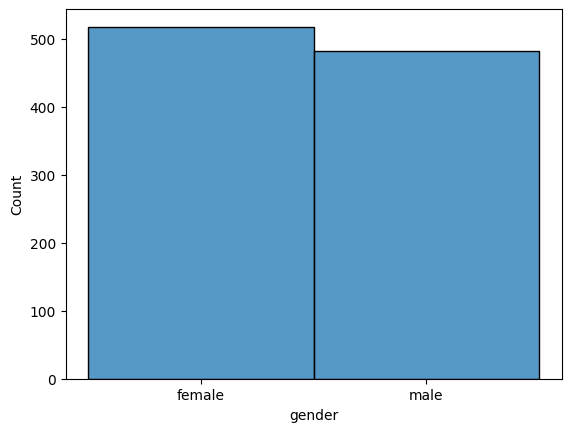

In [7]:
genders = sp['gender']
men = sp[(sp['gender'] == 'male')].shape[0] / sp.shape[0]

sns.histplot(genders)
genders.value_counts()

Гендер - бинарная категориальная переменная

Gender - бинарный признак с относительно равным распределением:

In [8]:
men_percent = int(men * 1000) / 10
print(f"{men_percent}% мужчин и {100 - men_percent}% женщин")

48.2% мужчин и 51.8% женщин


Race/ethnicity - раса/этническая принадлежность ученика

race/ethnicity
group C    319
group D    262
group B    190
group E    140
group A     89
Name: count, dtype: int64

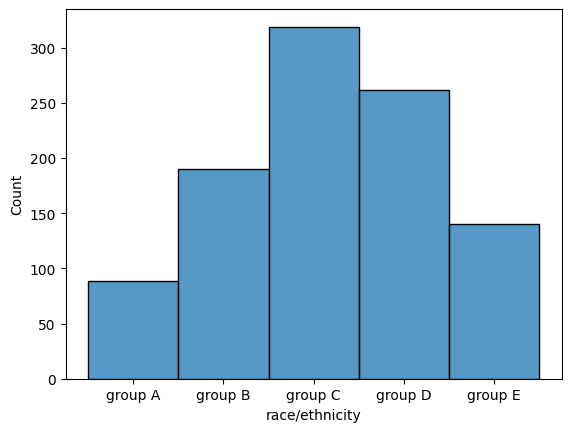

In [9]:
ethnicity = sp['race/ethnicity']

sns.histplot(ethnicity)
ethnicity.value_counts()

Всего 5 групп, где группа А - самая маленькая, а группа C самая большая

__Parental level of education - уровень образования родителей (например, высшее образование, среднее образование и т. д.)__

parental level of education
some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: count, dtype: int64

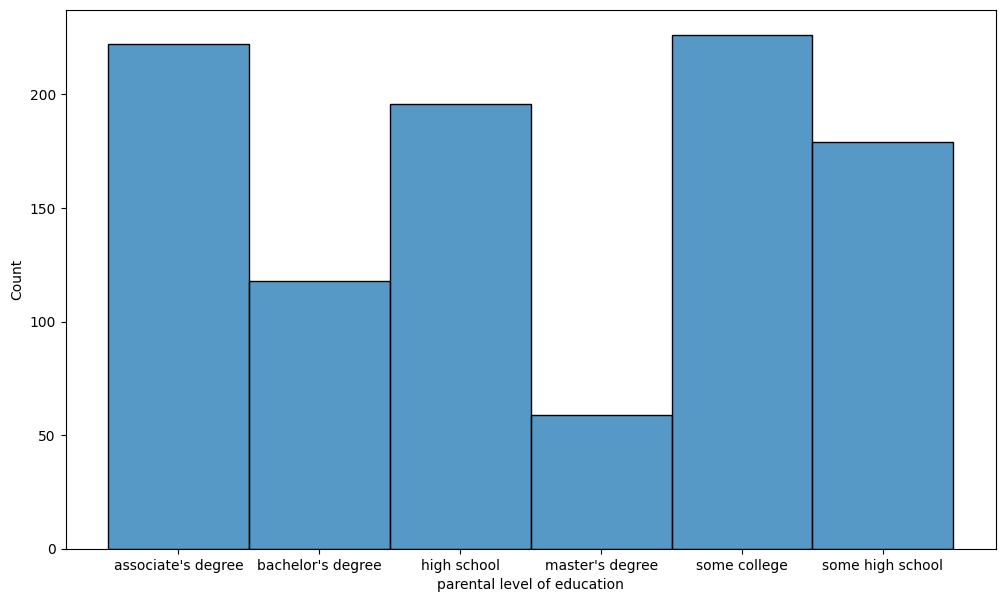

In [10]:
education_parents = sp['parental level of education']
plt.figure(figsize=(12, 7))

sns.histplot(education_parents)
education_parents.value_counts()

__Lunch - тип обеда ученика (бесплатный или платный)__

lunch
standard        645
free/reduced    355
Name: count, dtype: int64

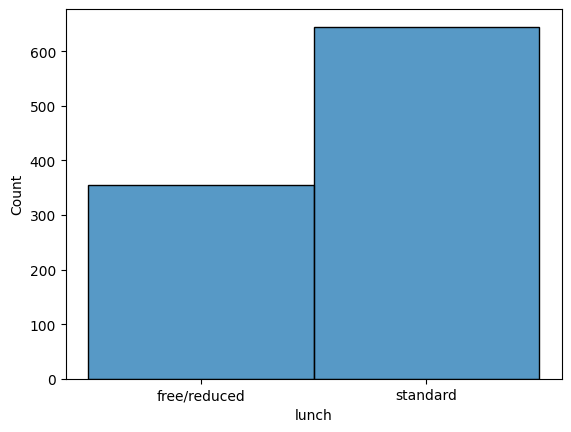

In [11]:
lunch = sp['lunch']

sns.histplot(lunch)
lunch.value_counts()

Lunch - бинарная категориальная переменная

__Test preparation course - прохождение учебных курсов подготовки к тестам (закончил или не закончил)__

test preparation course
none         642
completed    358
Name: count, dtype: int64

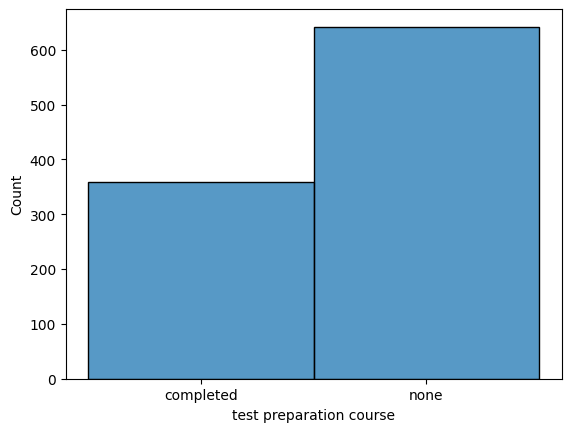

In [12]:
prep_test = sp['test preparation course']

sns.histplot(prep_test)
prep_test.value_counts()

Test preparation course - бинарная категориальная переменная

__Math score - баллы по математике__

<Axes: xlabel='math score', ylabel='Count'>

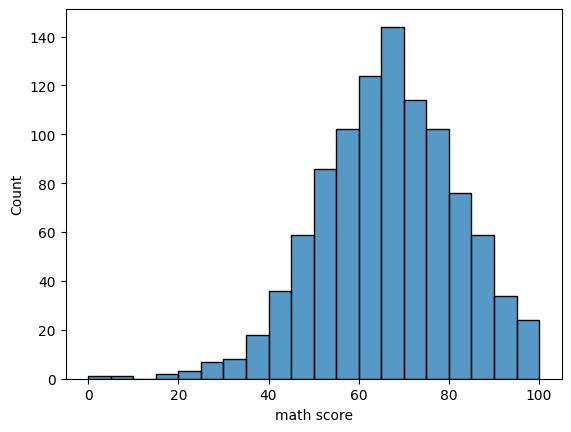

In [13]:
math_score = sp['math score']

sns.histplot(math_score, bins=20)

Распределение оценок по математике похоже на нормальное

__Reading score - баллы по чтению__

<Axes: xlabel='reading score', ylabel='Count'>

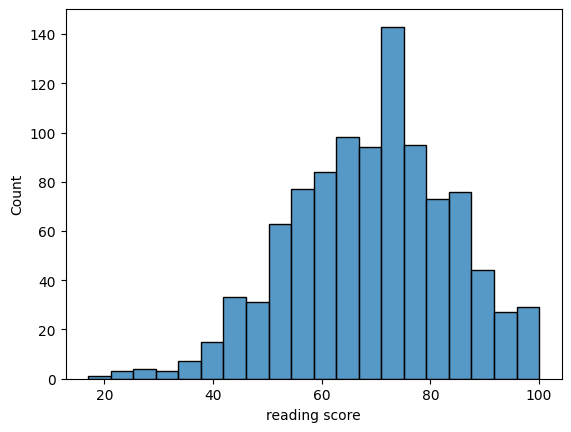

In [14]:
reading_score = sp['reading score']

sns.histplot(reading_score, bins=20)

Распределение балов по чтению меньше похоже на нормальное

__Writing score - баллы по письму__

<Axes: xlabel='writing score', ylabel='Count'>

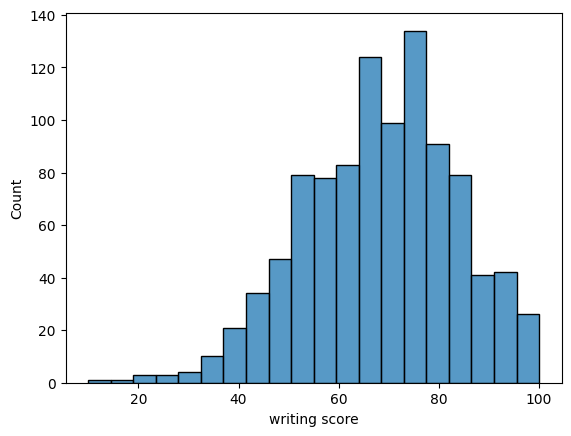

In [15]:
writing_score = sp['writing score']

sns.histplot(writing_score, bins=20)

Распределение похоже на нормальное, но хуже чем у предыдущих переменных

Построим диаграмму выбросов

<Axes: >

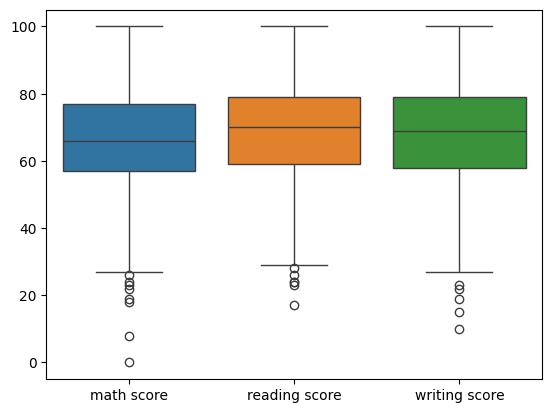

In [16]:
sns.boxplot(sp)

Построим диаграмму парных корреляций

Text(0.5, 1.0, 'Корреляции')

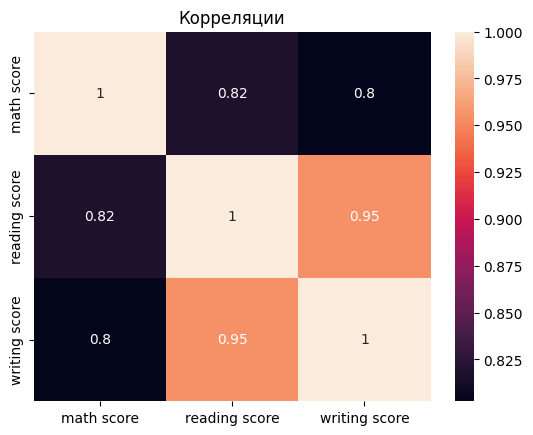

In [17]:
sns.heatmap(sp[['math score', 'reading score', 'writing score']].corr(), annot=True)
plt.title('Корреляции')

У оценок сильная корреляция, p >= 0,75

### 4. Подготовить данные для модели


#### 4.1 Преобразовать категориальные переменные в числовые с помощью метода one-hot encoding

In [18]:
sp_one_hot = sp.copy()

one_hot_encoder = OneHotEncoder(sparse_output=False)
variables = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

encoded_sp = pd.DataFrame(one_hot_encoder.fit_transform(sp_one_hot[variables]))

encoded_sp.columns = one_hot_encoder.get_feature_names_out()
sp_one_hot = sp_one_hot.join(encoded_sp)
sp_one_hot.drop(variables, axis=1, inplace=True)
sp_one_hot

,math score,reading score,writing score,gender_female,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_associate's degree,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
0,72,72,74,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,69,90,88,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,90,95,93,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,47,57,44,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,76,78,75,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,88,99,95,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
996,62,55,55,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
997,59,71,65,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
998,68,78,77,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


#### 4.2 Выделить целевую переменную (math score)

In [19]:
#variable_array_to_exclude = ['math score', 'reading score', 'writing score']
variable_array_to_exclude = ['math score']
X = sp_one_hot.drop(variable_array_to_exclude, axis=1)
y = sp_one_hot['math score']
#X = sp_one_hot[['reading score', 'writing score']]
#y = sp_one_hot['math score']

#### 4.3 Разделить данные на обучающую и тестовую выборки.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(700, 19) (300, 19) (700,) (300,)


Разбили генеральную совокупность на 70% обучающей и 30% тестовой выборки

#### 4.4 Произвести масштабирование числовых переменных

In [21]:
scalerSC = StandardScaler()
scalerMAC = MaxAbsScaler()
scalerSC.fit(X_train)
scalerMAC.fit(X_train)

X_test = pd.DataFrame(scalerMAC.transform(X_test), columns = X_test.columns)
X_train = pd.DataFrame(scalerMAC.transform(X_train), columns = X_train.columns)

### 5. Обучить модель линейной регрессии на обучающей выборке

In [22]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

### 6. Оценить качество модели на тестовой выборке с помощью метрик оценки 

* MSE - среднеквадратичная ошибка
* RMSE - корень из среднеквадратичной ошибки
* MAE - средняя абсолютная ошибка
* MAPE - средняя абсолютная процентная ошибка

| Мера | Сильные стороны | Слабые стороны |
|----------|----------|----------|
|MSE|Позволяет подчеркнуть большие отклонения, простота вычисления| Имеет тенденцию занижать качество модели, чувствительна к выбросам. Сложность интерпретации из-за квадратичной зависимости|
|RMSE|Простота интерпретации, поскольку измеряется в тех же единицах, что и целевая переменная|Имеет тенденцию занижать качество модели, чувствительна к выбросам|
|MAE|Менее чувствительна к выбросам в данных, чем среднеквадратическая, обеспечивает равномерную оценку того, насколько хорошо работает модель|Является размерной величиной, поэтому её интерпретация зависит от предметной области
|MAPE|Является безразмерной величиной, поэтому её интерпретация не зависит от предметной области|Нельзя использовать для наблюдений, в которых значения выходной переменной равны нулю|


In [23]:
mse_test = mean_squared_error(y_test, y_pred)
print(f"MSE (test): {mse_test}")

rmse_test = np.sqrt(mse_test)
print(f"RMSE (test): {rmse_test}")

mae_test = mean_absolute_error(y_test, y_pred)
print(f"MAE (test): {mae_test}")

mape_test = mean_absolute_percentage_error(y_pred, y_test)
print(f"MAPE (test): {(mape_test * 100).round(2)}%")


MSE (test): 31.33625
RMSE (test): 5.597879062645066
MAE (test): 4.435
MAPE (test): 7.61%


### 7. Провести анализ результатов

#### 7.1 Посмотреть значения весов модели

In [24]:
pd.DataFrame(lin_reg.coef_, index=X.columns)

,0
reading score,2.392218e+01
writing score,7.206421e+01
gender_female,-2.906082e+14
gender_male,-2.906082e+14
race/ethnicity_group A,-6.168345e+14
race/ethnicity_group B,-6.168345e+14
race/ethnicity_group C,-6.168345e+14
race/ethnicity_group D,-6.168345e+14
race/ethnicity_group E,-6.168345e+14
parental level of education_associate's degree,2.650454e+11


Маленькие коэффициенты регрессии у тех переменных, которые сильно коррелируют с math score

#### 7.2 Оценить значимость признаков

In [25]:
lin_reg.score(X_train, y_train)


0.8741257429044132

In [26]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             math score   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     500.3
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        00:03:19   Log-Likelihood:                -3090.7
No. Observations:                1000   AIC:                             6211.
Df Residuals:                     985   BIC:                             6285.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

Наименьшее влияние оказывают следующие предикторы: __"race/ethnicity_group A"__, __"parental level of education_high school"__ и __"parental level of education_some high school"__, т.к. p > 0,05

#### 7.3 Определить, какие переменные оказывают наибольшее влияние на оценку по математике

In [27]:
sp_one_hot.corr()['math score'].sort_values(key=abs)

parental level of education_some college          0.037056
race/ethnicity_group D                            0.050071
parental level of education_master's degree       0.060417
parental level of education_associate's degree    0.063228
race/ethnicity_group C                           -0.073387
parental level of education_bachelor's degree     0.079664
parental level of education_some high school     -0.079852
race/ethnicity_group B                           -0.084250
race/ethnicity_group A                           -0.091977
parental level of education_high school          -0.128725
gender_female                                    -0.167982
gender_male                                       0.167982
test preparation course_completed                 0.177702
test preparation course_none                     -0.177702
race/ethnicity_group E                            0.205855
lunch_standard                                    0.350877
lunch_free/reduced                               -0.3508

Math score имеет:
  1. статистически-незначимую корреляцию с __"parental level of education_some college"__
  2. сильную корреляцию с __"writing score"__ и __"reading score"__
  3. умеренную корреляцию с __"lunch_standard"__ и __"lunch_free/reduced"__
  4. слабую корреляцию с остальными переменными

#### 7.4 Проверить коэффициенты детерминации (R-squared) для оценки объяснимости модели

* R^2 - процент объяснённой дисперсии

In [28]:
r2_score(y_test, y_pred)

0.8740558191602752

Построенная модель объясняет 87% дисперсии

### 8. Визуализировать результаты

#### 8.1 Построить график реальных и предсказанных значений оценки по математике

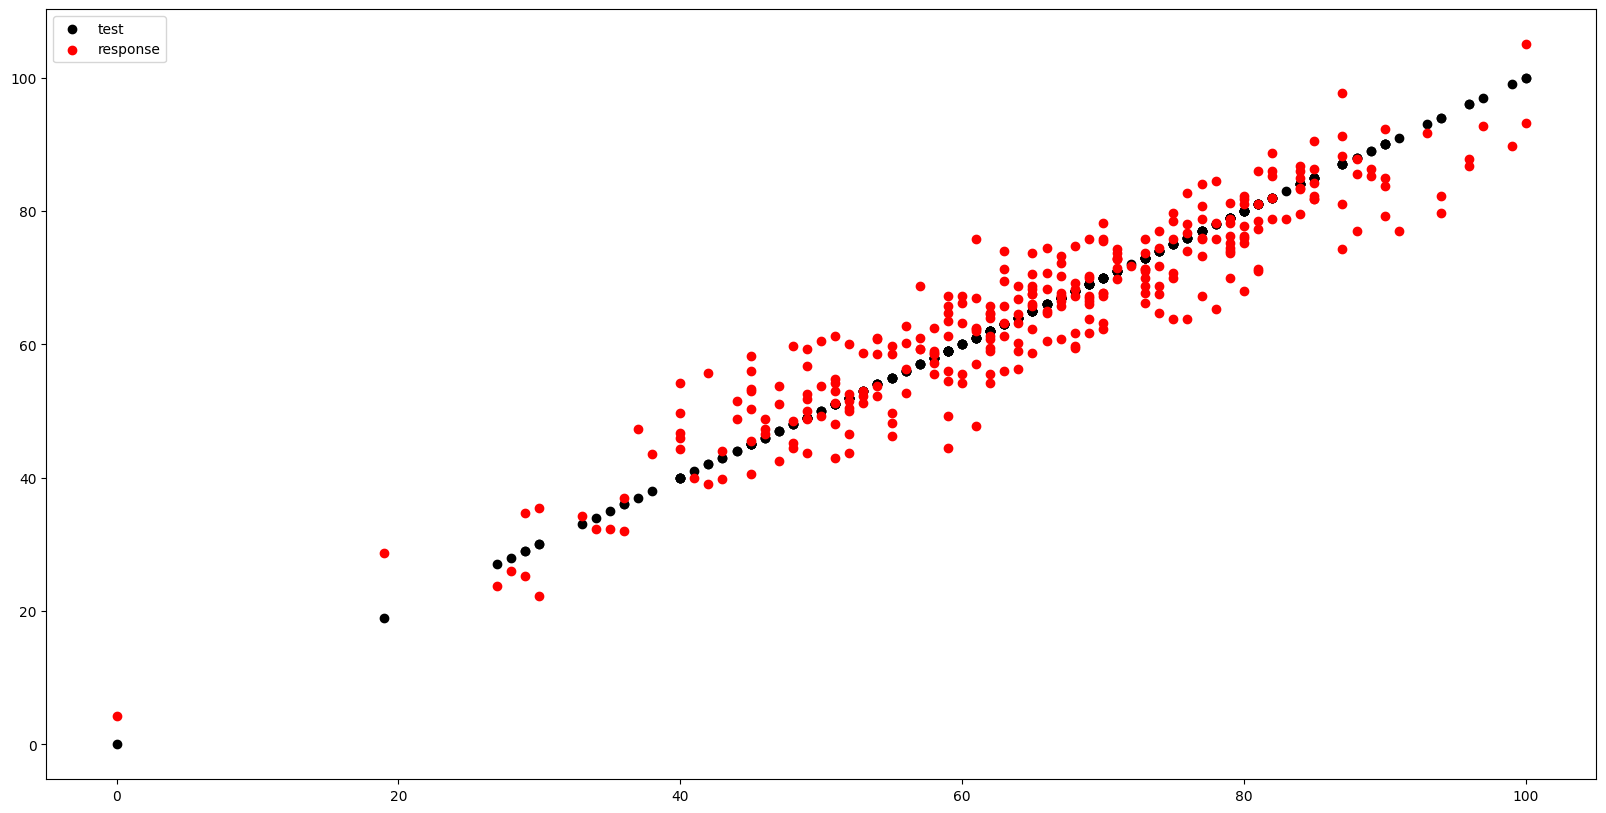

In [29]:
plt.figure(figsize=(20, 10))

plt.scatter(y_test, y_test, color='black', label='test')
plt.scatter(y_test, y_pred, color='red', label='response')

plt.legend()

#### 8.2 График остатков модели


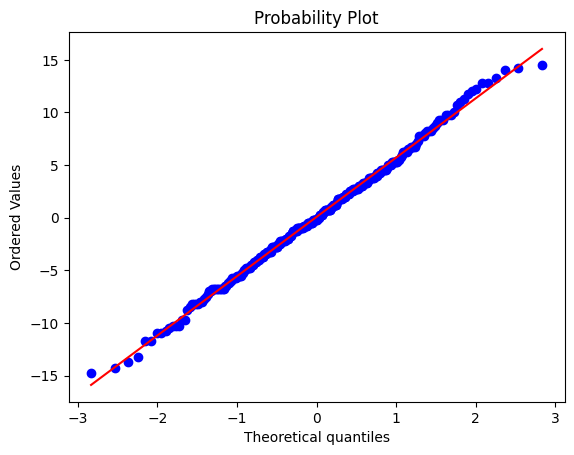

In [30]:
probplot(y_test - y_pred, dist = 'norm', plot = plt)
plt.show()

Нормальный вероятностный график остатков говорит о качестве модели. Чем ближе точки к прямой, тем лучше